In [1]:
import scanpy as sc
import omicverse as ov
import scvelo as scv

ov.ov_plot_set()



   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.4, Tutorials: https://omicverse.readthedocs.io/
All dependencies are satisfied.


In [2]:
ad = sc.read("data/depleted-bm-rna.h5ad")
ad

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivities', 'distances', 'knn

In [28]:
ad.X.max()

12.226059

<AxesSubplot: xlabel='X_umap1', ylabel='X_umap2'>

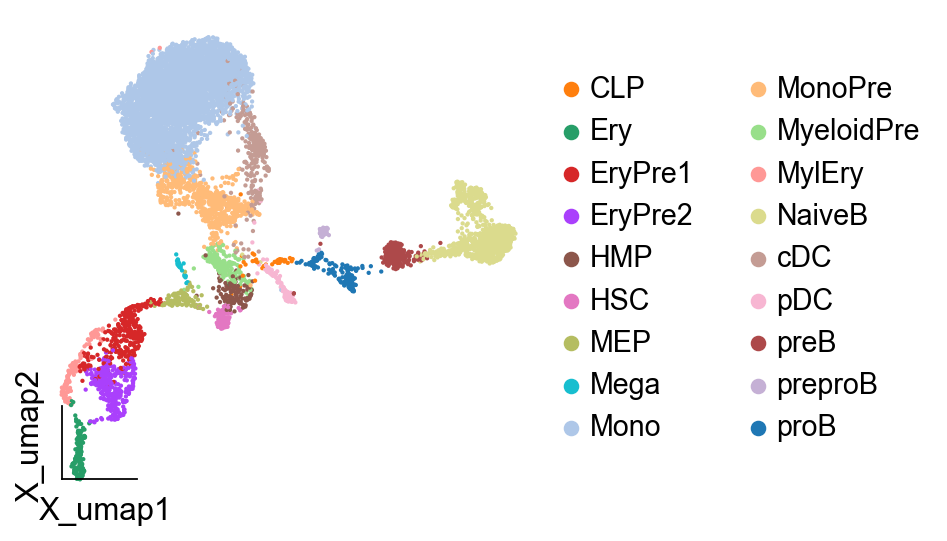

In [3]:
ov.pl.embedding(ad,
                basis="X_umap",
                color=['celltype'],title='',size=15,
                show=False, #legend_loc=None, add_outline=False, 
                frameon='small',legend_fontoutline=2,#ax=ax
)

In [5]:
ad.obs['celltype'].cat.categories


Index(['CLP', 'Ery', 'EryPre1', 'EryPre2', 'HMP', 'HSC', 'MEP', 'Mega', 'Mono',
       'MonoPre', 'MyeloidPre', 'MylEry', 'NaiveB', 'cDC', 'pDC', 'preB',
       'preproB', 'proB'],
      dtype='object')

In [7]:
new_order=['HSC','MEP','Mega','EryPre1','EryPre2','MylEry','Ery','HMP',
           'MyeloidPre','MonoPre','Mono','cDC',
           'CLP','pDC','proB','preproB','preB','NaiveB'
        ]
ad.obs['celltype']=ad.obs['celltype'].cat.reorder_categories(new_order)


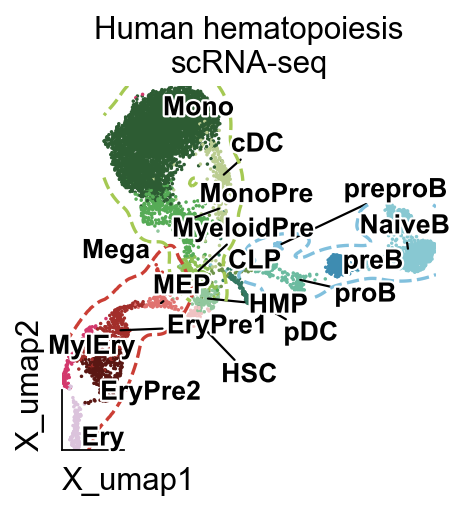

In [135]:
import matplotlib.pyplot as plt
from matplotlib import patheffects
fig, ax = plt.subplots(figsize=(3,3))
ov.pl.embedding(
    ad,
    basis="X_umap",
    color=['celltype'],title='',
    show=False,  
    frameon='small',
    size=10,
    palette=ov.pl.red_color[:7]+ov.pl.green_color[:6]+ov.pl.blue_color[:],
    ax=ax,
    legend_loc=None, add_outline=False, 
)

ov.pl.embedding_adjust(
    ad,
    basis="X_umap",
    groupby='celltype',
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize=12 ,weight='bold',
                     path_effects=[patheffects.withStroke(linewidth=2, foreground='w')] ),
)

ov.pl.contour(ax=ax,adata=ad,
        basis="X_umap",
        groupby='celltype',clusters=['MEP','Mega','EryPre1','EryPre2','MylEry','Ery'],
        contour_threshold=0.02,colors=ov.pl.red_color[2],linestyles='dashed')

ov.pl.contour(ax=ax,adata=ad,
        basis="X_umap",
        groupby='celltype',clusters=[
           'MyeloidPre','MonoPre','Mono','cDC',],
        contour_threshold=0.01,colors=ov.pl.green_color[6],linestyles='dashed')

ov.pl.contour(ax=ax,adata=ad,
        basis="X_umap",
        groupby='celltype',clusters=['proB','preproB','preB','NaiveB'],
        contour_threshold=0.02,colors=ov.pl.blue_color[2],linestyles='dashed')

plt.title('Human hematopoiesis\nscRNA-seq', fontsize=14)
plt.savefig(f'figures/hsc/umap-ct-33.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/hsc/umap-ct-33.pdf',dpi=300,bbox_inches='tight')



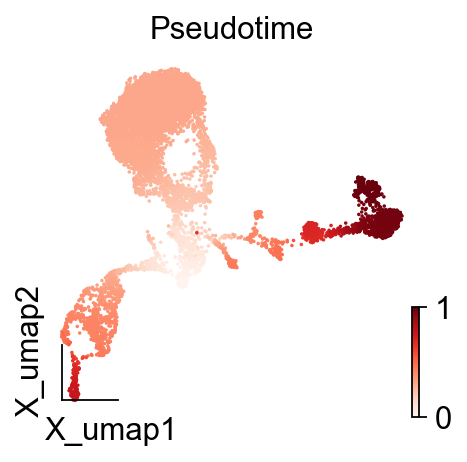

In [67]:
fig, ax = plt.subplots(figsize=(3,3))
ov.pl.embedding(
    ad,
    basis="X_umap",
    color=['palantir_pseudotime'],title='',
    show=False,  
    frameon='small',
    size=10,
    cmap='Reds',
    #palette=ov.pl.red_color[:7]+ov.pl.green_color[:6]+ov.pl.blue_color[:],
    ax=ax,
    legend_loc=None, add_outline=False, 
)
ax.set_title('Pseudotime', fontsize=14)
plt.savefig(f'figures/hsc/umap-pt-33.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/hsc/umap-pt-33.pdf',dpi=300,bbox_inches='tight')



## pearsonr

In [35]:
from scipy.stats import pearsonr
from tqdm import tqdm
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

def pearson_coef(adata, pesudotime, n_jobs=-1):
    # 提取时间序列并排序
    t_series = adata.obs[pesudotime].sort_values()
    pearson_li = []
    p_li = []

    # 转换数据以便于加速
    data_matrix = adata[t_series.index,:].X.toarray()

    # 定义计算单个基因的Pearson相关系数的函数
    def compute_pearson(i):
        expr_values = data_matrix[:, i]
        pe, p = pearsonr(t_series.values, expr_values)
        return pe, p

    # 并行计算
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_pearson)(i) for i in tqdm(range(data_matrix.shape[1]), desc="Calculating Pearson correlations")
    )

    # 将结果解包
    for pe, p in results:
        pearson_li.append(pe)
        p_li.append(p)
    
    # 创建结果数据框
    pearson_pd = pd.DataFrame({
        'pearson': pearson_li,
        'pvalue': p_li
    }, index=adata.var_names)
    
    return pearson_pd



res_pr=pearson_coef(ad,'palantir_pseudotime')


Calculating Pearson correlations: 100%|██████████| 17226/17226 [00:08<00:00, 2088.84it/s]


In [45]:
from statsmodels.stats.multitest import multipletests
import numpy as np
qvalue = multipletests(np.nan_to_num(np.array(res_pr['pvalue']),0), alpha=0.5, 
                               method='fdr_bh', is_sorted=False, returnsorted=False)
res_pr['qvalue']=qvalue[1]
res_pr['abs_pearson']=abs(res_pr['pearson'])
res_pr=res_pr.sort_values('pearson',ascending=False)

In [137]:
var_name=res_pr.loc[res_pr['abs_pearson']>np.max(res_pr['abs_pearson'])*0.5].index.tolist()

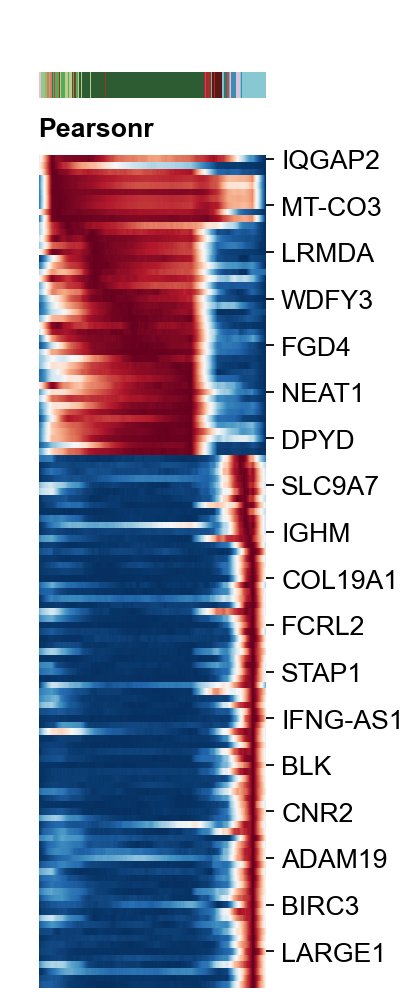

In [138]:
g=ov.utils.plot_heatmap(ad,var_names=var_name,
                  sortby='palantir_pseudotime',col_color='celltype',
                 n_convolve=1000,figsize=(1,6),show=False,)

g.fig.set_size_inches(2, 8)
g.fig.suptitle('Pearsonr',x=0.25,y=0.83,
               horizontalalignment='left',fontsize=12,fontweight='bold')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),fontsize=12)

plt.savefig(f'figures/hsc/heatmap_pearsonr.png',dpi=300,bbox_inches='tight')
#plt.savefig(f'pdf/hsc/heatmap_pearsonr.pdf',dpi=300,bbox_inches='tight')



## OmicFate

In [55]:
cfg_obj2=ov.single.Fate(ad,pseudotime='palantir_pseudotime')
cfg_obj2.model_init()
cfg_obj2.ATR(stop=500)

$MSE|RMSE|MAE|R^2$:0.0024|0.049|0.037|0.95
coef_threshold:0.0009673292515799403, r2:0.9458897232697306


,coef_threshold,r2
0,0.002444,0.661107
1,0.002407,0.728704
2,0.002259,0.752481
3,0.002137,0.783143
4,0.002099,0.786696
...,...,...
495,0.000610,0.964707
496,0.000610,0.964685
497,0.000610,0.964671
498,0.000609,0.964718


Text(0.5, 1.0, 'HSC\nOmicFate')

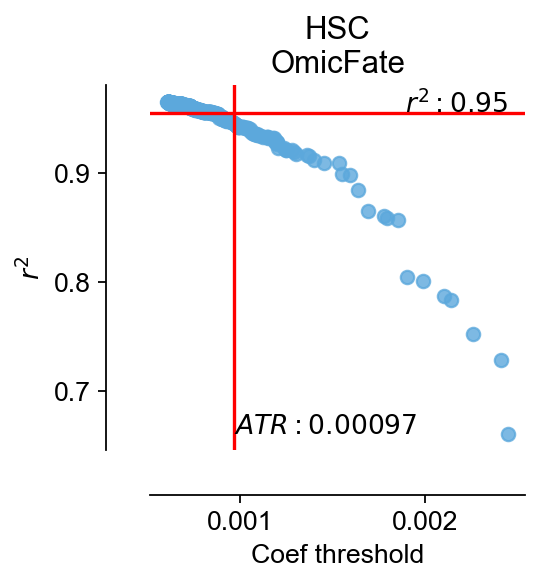

In [57]:
fig,ax=cfg_obj2.plot_filtering(color='#5ca8dc')
ax.set_title('HSC\nOmicFate')

In [58]:
res=cfg_obj2.model_fit()

$MSE|RMSE|MAE|R^2$:0.003|0.055|0.039|0.94


(<Figure size 240x240 with 1 Axes>,
 <AxesSubplot: title={'center': 'Dimension: 17226'}, xlabel='Raw', ylabel='Predicted'>)

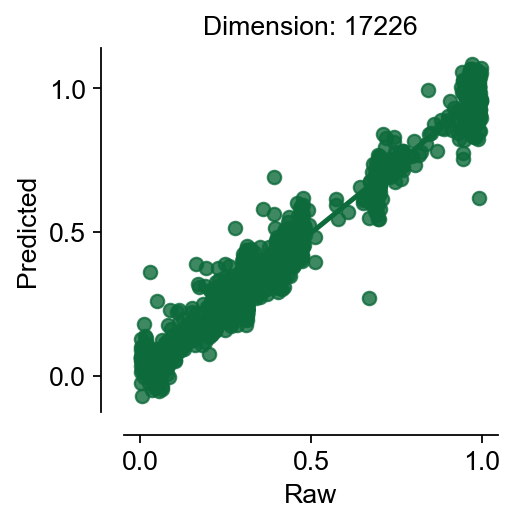

In [59]:
cfg_obj2.plot_fitting(type='raw')

Text(1.1, 0.5, 'rmse')

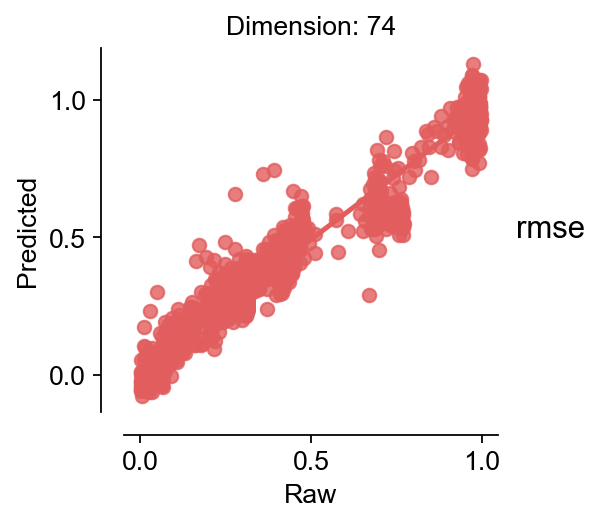

In [60]:
fig,ax=cfg_obj2.plot_fitting(type='filter',color='#e25d5d')
ax.text(1.1,0.5,'rmse')

In [139]:
var_name=cfg_obj2.filter_coef.index.tolist()

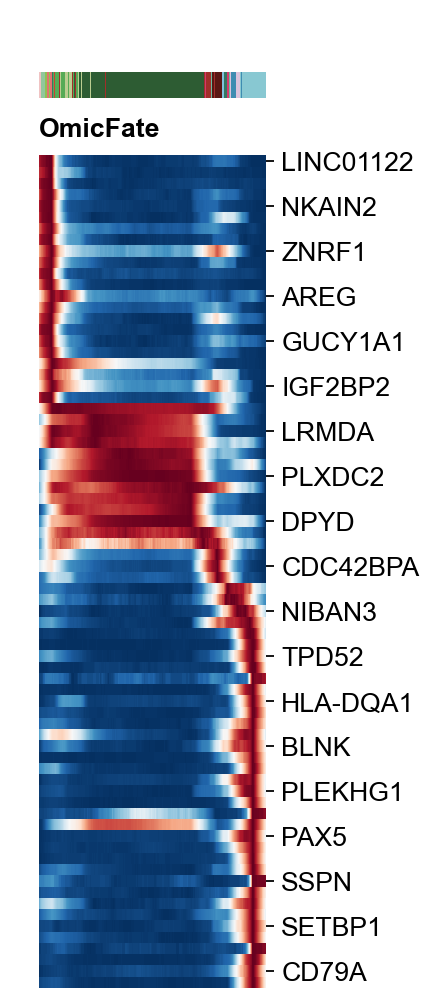

In [140]:
g=ov.utils.plot_heatmap(ad,var_names=var_name,
                  sortby='palantir_pseudotime',col_color='celltype',
                 n_convolve=1000,figsize=(1,6),show=False,)

g.fig.set_size_inches(2, 8)
g.fig.suptitle('OmicFate',x=0.25,y=0.83,
               horizontalalignment='left',fontsize=12,fontweight='bold')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),fontsize=12)

plt.savefig(f'figures/hsc/heatmap_omicfate.png',dpi=300,bbox_inches='tight')
#plt.savefig(f'pdf/hsc/heatmap_omicfate.pdf',dpi=300,bbox_inches='tight')



## Metric

In [125]:
res_pd=pd.DataFrame(columns=['mse','rmse','mae','r2','num_genes'])

In [126]:
#pearsonr
import numpy as np
#var_genes=p_pd.sort_values('pvalue').index.tolist()[:50]
var_genes=res_pr.loc[res_pr['abs_pearson']>np.max(res_pr['abs_pearson'])*0.5].index
print('Pr',np.max(res_pr['abs_pearson'])*0.5)
cfg_obj_test=ov.single.Fate(ad[:,var_genes],
                                 pseudotime='palantir_pseudotime')
a=cfg_obj_test.model_init()
len(var_genes)

Pr 0.40458127146503786
$MSE|RMSE|MAE|R^2$:0.0043|0.065|0.047|0.92


125

In [127]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_test=cfg_obj_test.y_test_r
y_pred=pd.Series(cfg_obj_test.y_pred_r)
y_pred.index=y_test.index
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
res_pd.loc['pearsonr']=[mse,rmse,mae,r2,len(var_genes)]
res_pd.head()

,mse,rmse,mae,r2,num_genes
pearsonr,0.004276,0.065394,0.047175,0.920113,125.0


In [128]:
#cfg genes
var_genes=cfg_obj2.filter_coef.index.tolist()
cfg_obj_test=ov.single.Fate(ad[:,var_genes],
                                 pseudotime='palantir_pseudotime')
a=cfg_obj_test.model_init()
len(var_genes)

$MSE|RMSE|MAE|R^2$:0.003|0.055|0.039|0.94


74

In [129]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_test=cfg_obj_test.y_test_r
y_pred=pd.Series(cfg_obj_test.y_pred_r)
y_pred.index=y_test.index
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
res_pd.loc['omicfate']=[mse,rmse,mae,r2,len(var_genes)]
res_pd.head()

,mse,rmse,mae,r2,num_genes
pearsonr,0.004276,0.065394,0.047175,0.920113,125.0
omicfate,0.003026,0.055005,0.038913,0.943480,74.0


In [130]:
kt_li=[]
lr_li=[]
for var_name in [res_pr.loc[res_pr['abs_pearson']>np.max(res_pr['abs_pearson'])*0.7].index,
                cfg_obj2.filter_coef.index.tolist()]:
    gt_obj=ov.single.gene_trends(ad,'palantir_pseudotime',var_name)
    gt_obj.calculate(n_convolve=100)
    kt_li.append(gt_obj.kt[0])
    import numpy as np
    max_avg_li=[]
    for data_array in gt_obj.normalized_data:
        # 找到值大于 0.8 的元素的索引
        indices = np.where(data_array >= np.max(data_array)*0.8)
        
        # 计算索引的平均值
        average_index = np.mean(indices)
        #print(average_index)
        max_avg_li.append(average_index)
    res=evaluate_model(range(len(max_avg_li)),
              max_avg_li)
    #kt_li.append(gt_obj.kt[0])
    lr_li.append(res[0])
res_pd['Kendalltau']=kt_li
res_pd['Linregress']=lr_li

In [131]:
res_pd.head()

,mse,rmse,mae,r2,num_genes,Kendalltau,Linregress
pearsonr,0.004276,0.065394,0.047175,0.920113,125.0,0.382785,0.372667
omicfate,0.003026,0.055005,0.038913,0.943480,74.0,0.690959,0.559452


In [132]:
res_pd.to_csv('result/hsc_raw_coef.csv')

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def evaluate_model(X,y):
    #X = data[['pseudotime']]
    #y = data['genes']
    X=np.array(X).reshape(-1, 1)
    
    # 线性回归模型
    model = LinearRegression()
    model.fit(X, y)
    
    # 预测值
    y_pred = model.predict(X)
    
    # 计算指标
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    
    # 综合指标
    comprehensive_score = 100 * r2 - 2 * mse - mae
    
    return r2, mse, mae, comprehensive_score
#evaluate_model(range(len(max_avg_li)),
  #            max_avg_li)#

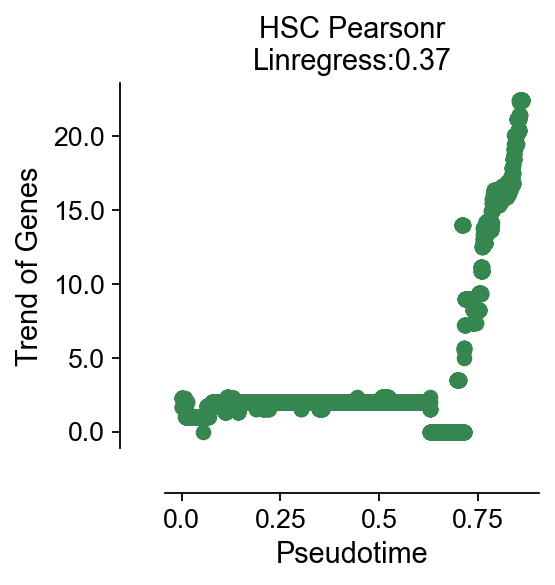

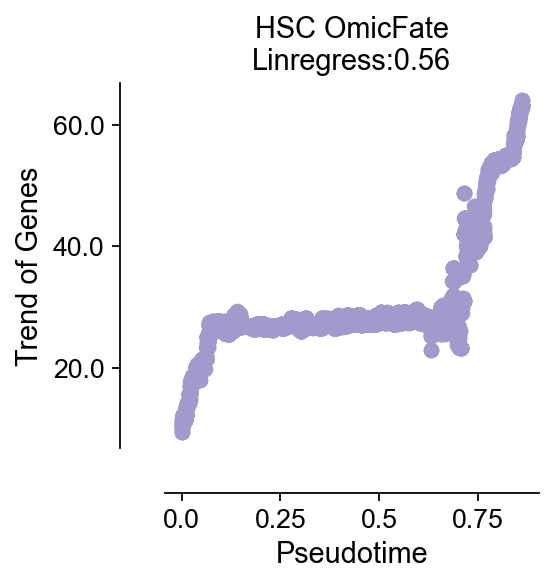

In [144]:
for var_name,color,name in zip([res_pr.loc[res_pr['abs_pearson']>np.max(res_pr['abs_pearson'])*0.7].index,
                cfg_obj2.filter_coef.index.tolist()],
                   [ov.utils.sc_color[1],ov.utils.sc_color[2]],
                              ['Pearsonr','OmicFate']):
    gt_obj=ov.single.gene_trends(ad,'palantir_pseudotime',var_name)
    gt_obj.calculate(n_convolve=100)

    import numpy as np
    max_avg_li=[]
    for data_array in gt_obj.normalized_data:
        # 找到值大于 0.8 的元素的索引
        indices = np.where(data_array >= np.max(data_array)*0.8)
        
        # 计算索引的平均值
        average_index = np.mean(indices)
        #print(average_index)
        max_avg_li.append(average_index)
    res=evaluate_model(range(len(max_avg_li)),
              max_avg_li)

    fig,ax=gt_obj.plot_trend(color=color,figsize=(3,3))
    ax.set_title('HSC {}\nLinregress:{:.2}'.format(name,res[0]),fontsize=13)
    ax.set_xticklabels([round(i/10000,2) for i in ax.get_xticks()],  fontsize=12,rotation=0)
    ax.set_yticklabels([round(i,2) for i in ax.get_yticks()], fontsize=12)
    ax.set_ylabel('Trend of Genes',fontsize=13)
    ax.set_xlabel('Pseudotime',fontsize=13)
    #ax.set_xticklabels([0,0.25,0.5,0.75,1])
    plt.savefig(f'figures/hsc/scatter_hsc_{name}.png',dpi=300,bbox_inches='tight')
    plt.savefig(f'pdf/hsc/scatter_hsc_{name}.pdf',dpi=300,bbox_inches='tight')

    